In [2]:
import numpy as np
#import statsmodels.api as sm
from scipy import stats
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [108]:
path_home = '/Users/yixinglu/Documents/UCD/LAB/encap carrier model/results/encapsulation_data'
os.chdir(path_home)

## FTIR+PLSR model

In [109]:
# pre-processed ftir data
ftir_train = pd.read_csv('ftir_train_emsc_sg_2.csv',index_col=0)
ftir_test = pd.read_csv('ftir_test_emsc_sg_2.csv',index_col=0)
ftir_compile = pd.concat([ftir_train,ftir_test])
ftir_compile_long=pd.melt(ftir_compile,id_vars=['strain_id','rep','biological_rep'],var_name='wavenumber')
ftir_compile_long['wavenumber']=ftir_compile_long['wavenumber'].astype('float64')

In [116]:
# cell characterization measurements
cell_info = pd.read_csv('../cell characterization/cell_info_compile.csv').drop(['lipid_index','HPBI'],axis=1)
lipid_peaks = pd.read_csv('../FTIR/lipid_peaks.txt',sep=',')
#lipid_peaks = lipid_peaks.drop('1456.281',axis=1)
protein_peaks = pd.read_csv('../FTIR/protein_peaks.txt',sep=',')
lipid_peaks = list(lipid_peaks.columns[1:].astype('float64'))
protein_peaks = list(protein_peaks.columns[1:].astype('float64'))

In [113]:
# dataset for plsr model
# train
strain_id_list = [(x,y) for (x,y),_ in ftir_train.groupby(['strain_id','biological_rep'],as_index=False)]
cellinfo_groups=[x for _,x in cell_info.groupby(['strain_id','biological_rep'],as_index=False)]
ftir_groups=[x for _,x in ftir_train.groupby(['strain_id','biological_rep'],as_index=False)]

imputed_cellinfo_ind=[]
ftir_ind=None

import random
random.seed(2022)
for i,(strain,biorep) in enumerate(strain_id_list):
    # target number of samples
    n_target = ftir_groups[i].shape[0]
    # impute
    imputed_cellinfo_ind += np.random.choice(cellinfo_groups[i].index,n_target).tolist()
    if i==0:
        ftir_ind=ftir_groups[i].index
    else:
        ftir_ind=ftir_ind.union(ftir_groups[i].index,sort=False)
        
ftir_cellinfo_train=pd.concat([ftir_train.loc[ftir_ind,:].reset_index(drop=True),
                     cell_info.loc[imputed_cellinfo_ind,['lipid_fraction','protein_fraction']].reset_index(drop=True)],
                     axis=1).set_index(ftir_ind,drop=True)

In [114]:
# test
strain_id_list = [(x,y) for (x,y),_ in ftir_test.groupby(['strain_id','biological_rep'],as_index=False)]
cellinfo_groups=[x for _,x in cell_info.groupby(['strain_id','biological_rep'],as_index=False)]
ftir_groups=[x for _,x in ftir_test.groupby(['strain_id','biological_rep'],as_index=False)]

imputed_cellinfo_ind=[]
ftir_ind=None

import random
random.seed(2022)
for i,(strain,biorep) in enumerate(strain_id_list):
    # target number of samples
    n_target = ftir_groups[i].shape[0]
    # impute
    imputed_cellinfo_ind += np.random.choice(cellinfo_groups[i].index,n_target).tolist()
    if i==0:
        ftir_ind=ftir_groups[i].index
    else:
        ftir_ind=ftir_ind.union(ftir_groups[i].index,sort=False)
        
ftir_cellinfo_test=pd.concat([ftir_test.loc[ftir_ind,:].reset_index(drop=True),
                     cell_info.loc[imputed_cellinfo_ind,['lipid_fraction','protein_fraction']].reset_index(drop=True)],
                     axis=1).set_index(ftir_ind,drop=True)

### PLSR with FTIR fingerprints

In [117]:
# lipid regions: 3100-2800, 1800-700
wavelengths = [float(x) for x in list(ftir_train.columns[3:])]
lipid_region1_index = [i+3 for i in range(len(wavelengths)) if wavelengths[i]>=2800 and wavelengths[i]<=3100]
X_train_l1 = ftir_cellinfo_train.iloc[:,lipid_region1_index]
X_test_l1 = ftir_cellinfo_test.iloc[:,lipid_region1_index]

lipid_region2_index = [i+3 for i in range(len(wavelengths)) if wavelengths[i]>=700 and wavelengths[i]<=1800]
X_train_l2 = ftir_cellinfo_train.iloc[:,lipid_region2_index]
X_test_l2 = ftir_cellinfo_test.iloc[:,lipid_region2_index]

lipid_peaks_colname = []
for peaks in lipid_peaks:
    lipid_peaks_colname+=[i for i in wavelengths if abs(i-peaks)<0.95]
    
# protein region: 1700-1400
protein_region_index = [i+3 for i in range(len(wavelengths)) if wavelengths[i]>=1400 and wavelengths[i]<=1700]
X_train_p = ftir_cellinfo_train.iloc[:,protein_region_index]
X_test_p = ftir_cellinfo_test.iloc[:,protein_region_index]

protein_peaks_colname = []
for peaks in protein_peaks:
    protein_peaks_colname+=[i for i in wavelengths if abs(i-peaks)<0.95]

lipid_train,lipid_test = ftir_cellinfo_train['lipid_fraction'],ftir_cellinfo_test['lipid_fraction']
protein_train,protein_test = ftir_cellinfo_train['protein_fraction'],ftir_cellinfo_test['protein_fraction']

In [120]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import RepeatedKFold, cross_val_score

def PLSR_score_recording(X,y,max_n_components,cv):
    MSE = []
    R2 = []
    n = len(X)
    
    # Calculate MSE and R2 with only the intercept
    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        mse = -1*cross_val_score(PLSRegression(n_components=1),
               np.ones((n,1)), y, cv=cv, scoring='neg_mean_squared_error').mean()    
        MSE.append(mse)
        r2 = cross_val_score(PLSRegression(n_components=1),
               np.ones((n,1)), y, cv=cv, scoring='explained_variance').mean()
        R2.append(r2)

    # Calculate MSE and R2 using cross-validation, adding one component at a time
    for i in np.arange(1, max_n_components+1):
        pls = PLSRegression(n_components=i,scale=False)
        mse = -1*cross_val_score(pls, X, y, cv=cv,
                   scoring='neg_mean_squared_error').mean()
        MSE.append(mse)
        r2 = cross_val_score(pls, X, y, cv=cv,
                   scoring='explained_variance').mean()
        R2.append(r2)
    return MSE,R2

### Lipid region 1

In [ ]:
#define cross-validation method
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1243)

# lipid region 1 -> lipid fraction
l1_mse, l1_r2 = PLSR_score_recording(X_train_l1,lipid_train,20,cv)

## Load data

In [71]:
# feature set 1
X_fs1_train = pd.read_csv('fs1_train.csv',index_col=0).drop(columns='protein_interaction_score',axis=1)
X_fs1_test = pd.read_csv('fs1_test.csv',index_col=0).drop(columns='protein_interaction_score',axis=1)
# feature set 2
X_fs2_train = pd.read_csv('fs2_train.csv',index_col=0)
X_fs2_test = pd.read_csv('fs2_test.csv',index_col=0)
# feature set 3
X_fs3_train = pd.read_csv('fs3_train.csv',index_col=0)
X_fs3_test = pd.read_csv('fs3_test.csv',index_col=0)

In [72]:
Y_train = X_fs1_train['efficiency']
Y_test = X_fs1_test['efficiency']
X_fs1_train = X_fs1_train.drop(columns='efficiency',axis=1)
X_fs1_test = X_fs1_test.drop(columns='efficiency',axis=1)

## Helper function

In [23]:
def pred_vs_true_plot(y_pred_train,y_true_train,mse_train,y_pred_test,y_true_test,mse_test,suptitle):
    fig,ax=plt.subplots(1,2,figsize=(15,6))
    fig.suptitle(suptitle,fontsize=20)
    train=sns.scatterplot(x=y_true_train,y=y_pred_train,ax=ax[0])
    ax[0].plot([0, 1], [0, 1], color='red', linestyle='-', linewidth=1.5)
    ax[0].tick_params(labelsize=20)
    ax[0].set_xlabel('True efficiency',fontsize=20)
    ax[0].set_ylabel('Predicted efficiency',fontsize=20)
    ax[0].set_title('Train set',fontsize=20)
    train.annotate(f"MSE={np.round(mse_train,5)}",
                       (0.2,0.9), xytext=(0,0),ha='center', va='center',
                       size=16,
                       textcoords='offset points')

    test=sns.scatterplot(x=y_true_test,y=y_pred_test,ax=ax[1])
    ax[1].plot([0, 1], [0, 1], color='red', linestyle='-', linewidth=1.5)
    ax[1].tick_params(labelsize=20)
    ax[1].set_xlabel('True efficiency',fontsize=20)
    #ax[1].set_ylabel('Predicted efficiency',fontsize=40)
    ax[1].set_title('Test set',fontsize=20)
    _=test.annotate(f"MSE={np.round(mse_test,5)}",
                       (0.2,0.9), xytext=(0,0),ha='center', va='center',
                       size=15,
                       textcoords='offset points')

## Model construction

### Feature set 1

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [78]:
# feature set 1: only cell info
# define model
rf = RandomForestRegressor(random_state=1243,n_estimators=200)
# hyperparameters
param_grid = {"max_samples":[0.2,0.4,0.6],"max_features":[0.3,0.5,0.7,1]}
# grid search
fs1_gridsearch = GridSearchCV(rf,param_grid = param_grid,scoring='neg_mean_squared_error',cv=5)
fs1_gridsearch.fit(X_fs1_train,Y_train)

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(n_estimators=200,
                                             random_state=1243),
             param_grid={'max_features': [0.3, 0.5, 0.7, 1],
                         'max_samples': [0.2, 0.4, 0.6]},
             scoring='neg_mean_squared_error')

In [79]:
fs1_best_params=fs1_gridsearch.best_params_
fs1_best_params

{'max_features': 0.5, 'max_samples': 0.4}

In [ ]:
# impurity based feature importance
fi_std_fs1=np.std([tree.feature_importances_ for tree in fs1_gridsearch.best_estimator_.estimators_],axis=0)
fi_fs1 = fs1_gridsearch.best_estimator_.feature_importances_
pd.DataFrame({'features':X_fs1_train.columns,'importance':fi_fs1,'std':fi_std_fs1})

In [80]:
# permutation importance
from sklearn.inspection import permutation_importance

permut_fi_fs1 = permutation_importance(fs1_gridsearch.best_estimator_, X_fs1_test, Y_test, n_repeats=10, random_state=1243)
fs1_fi = pd.DataFrame({'features':X_fs1_train.columns,'importance':permut_fi_fs1 .importances_mean,'std':permut_fi_fs1 .importances_std})
#fs1_fi=fs1_fi.drop(2)
fs1_fi

,features,importance,std
0,ethanol,0.741377,0.114661
1,logP_PM,1.192554,0.196339
2,lipid_fraction,0.032004,0.009918
3,protein_fraction,0.027933,0.013207


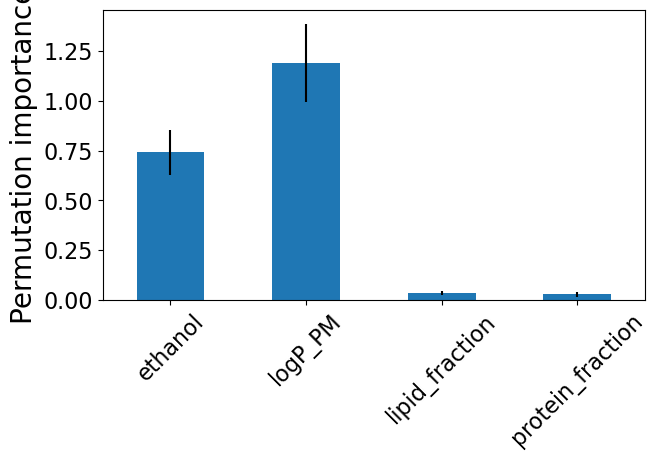

In [81]:
fig, ax = plt.subplots(figsize=(7,5))
fs1_fi.plot.bar(x='features',y='importance', yerr='std',ax=ax)
ax.set_xlabel(None)
ax.tick_params('x',rotation=45,labelsize=16)
ax.tick_params('y',labelsize=16)
ax.set_ylabel('Permutation importance',fontsize=20)
ax.get_legend().remove()
plt.subplots_adjust(bottom=0.3)
plt.savefig('encapsulation_output/fs1_fi.png')

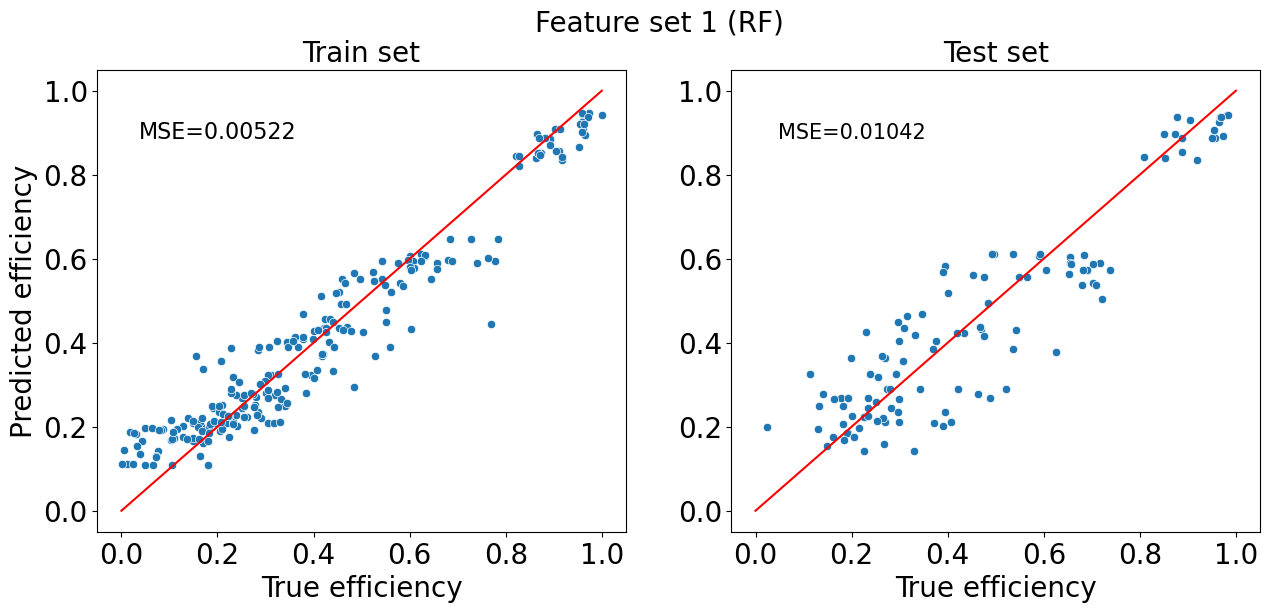

In [102]:
# mse 
from sklearn.metrics import mean_squared_error, r2_score
fs1_pred_train = fs1_gridsearch.predict(X_fs1_train)
fs1_mse_train = mean_squared_error(Y_train,fs1_pred_train)
fs1_r2_train = r2_score(Y_train,fs1_pred_train)
fs1_pred_test = fs1_gridsearch.predict(X_fs1_test)
fs1_mse_test = mean_squared_error(Y_test,fs1_pred_test)
fs1_r2_test = r2_score(Y_test,fs1_pred_test)
train_mse = []
test_mse = []
train_r2=[]
test_r2=[]
fs_name = ['Feasure set 1']
train_mse.append(fs1_mse_train)
train_r2.append(fs1_r2_train)
test_mse.append(fs1_mse_test)
test_r2.append(fs1_r2_test)
pred_vs_true_plot(fs1_pred_train,Y_train,fs1_mse_train,fs1_pred_test,Y_test,fs1_mse_test,'Feature set 1 (RF)')
plt.savefig('encapsulation_output/FS1_rf_pred_vs_true.png')

### Feature set 2

In [83]:
# feature set 2: plsr components
# define model
rf = RandomForestRegressor(random_state=1243,n_estimators=200)
# hyperparameters
param_grid = {"max_samples":[0.2,0.4,0.6],"max_features":[0.3,0.5,0.7,1]}
# grid search
fs2_gridsearch = GridSearchCV(rf,param_grid = param_grid,scoring='neg_mean_squared_error',cv=5)
fs2_gridsearch.fit(X_fs2_train,Y_train)

fs2_gridsearch.best_params_

{'max_features': 0.7, 'max_samples': 0.6}

In [ ]:
# impurity based feature importance
fi_std_fs2=np.std([tree.feature_importances_ for tree in fs2_gridsearch.best_estimator_.estimators_],axis=0)
fi_fs2 = fs2_gridsearch.best_estimator_.feature_importances_
pd.DataFrame({'features':X_fs2_train.columns,'importance':fi_fs2,'std':fi_std_fs2})

In [ ]:
# permutation importance
permut_fi_fs2 = permutation_importance(fs2_gridsearch.best_estimator_, X_fs2_test, Y_test, n_repeats=10, random_state=1243)
pd.DataFrame({'features':X_fs2_train.columns,'importance':permut_fi_fs2 .importances_mean,'std':permut_fi_fs2 .importances_std})

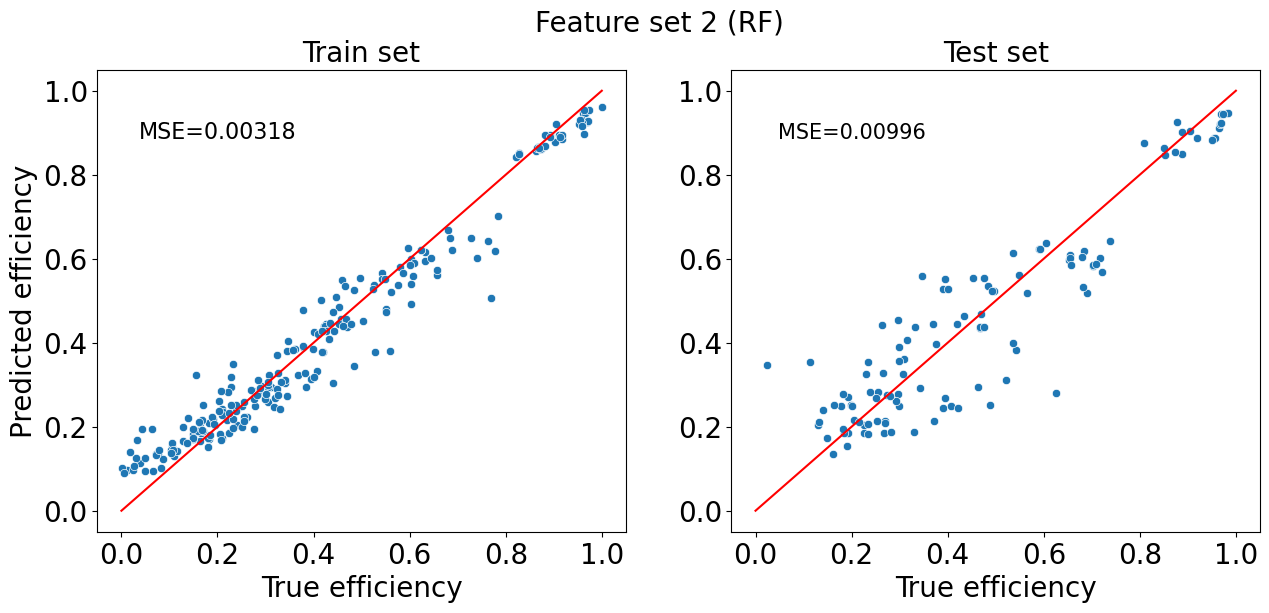

In [103]:
# mse
from sklearn.metrics import mean_squared_error, r2_score
fs2_pred_train = fs2_gridsearch.predict(X_fs2_train)
fs2_mse_train = mean_squared_error(Y_train,fs2_pred_train)
fs2_r2_train = r2_score(Y_train,fs2_pred_train)
fs2_pred_test = fs2_gridsearch.predict(X_fs2_test)
fs2_mse_test = mean_squared_error(Y_test,fs2_pred_test)
fs2_r2_test = r2_score(Y_test,fs2_pred_test)
train_mse.append(fs2_mse_train)
train_r2.append(fs2_r2_train)
test_mse.append(fs2_mse_test)
test_r2.append(fs2_r2_test)
fs_name.append('Feature set 2')
pred_vs_true_plot(fs2_pred_train,Y_train,fs2_mse_train,fs2_pred_test,Y_test,fs2_mse_test,'Feature set 2 (RF)')
plt.savefig('encapsulation_output/fs2_rf_pred_vs_true.png')

### Feature set 3

In [85]:
# feature set 3: protein and lipid peaks

# hyperparameters
param_grid = {"max_samples":[0.2,0.4,0.6],"max_features":[0.3,0.5,0.7,1]}
# grid search
fs3_gridsearch = GridSearchCV(rf,param_grid = param_grid,scoring='neg_mean_squared_error',cv=5)
fs3_gridsearch.fit(X_fs3_train,Y_train)

fs3_gridsearch.best_params_

{'max_features': 0.7, 'max_samples': 0.6}

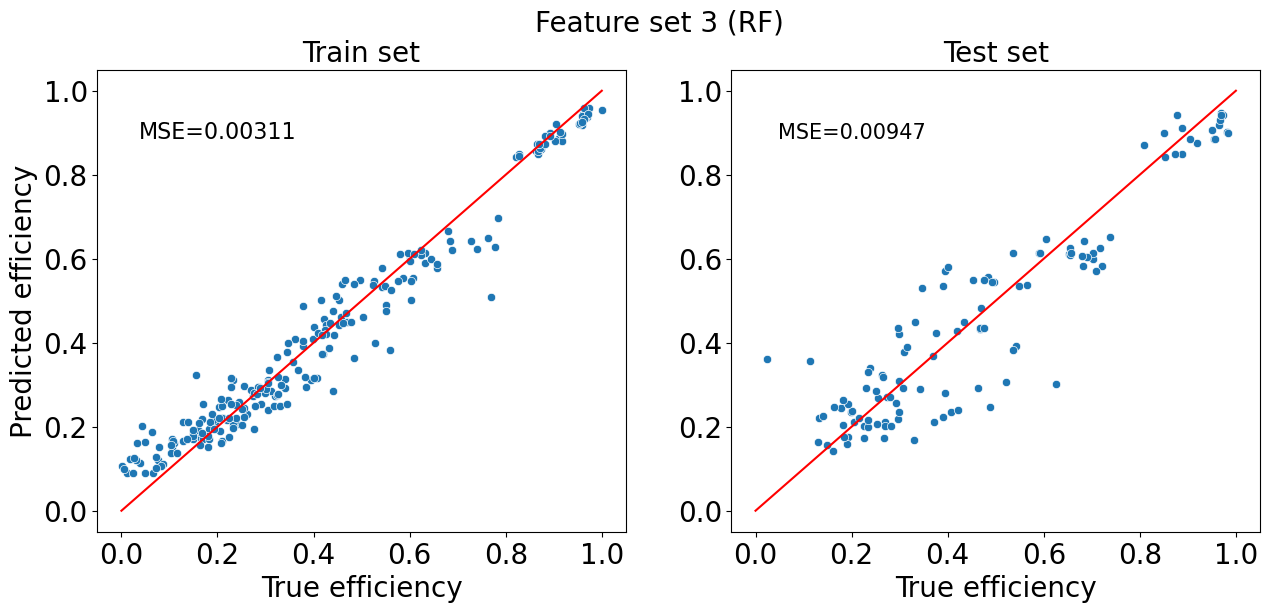

In [104]:
# mse
fs3_pred_train = fs3_gridsearch.predict(X_fs3_train)
fs3_mse_train = mean_squared_error(Y_train,fs3_pred_train)
fs3_r2_train=r2_score(Y_train,fs3_pred_train)
fs3_pred_test = fs3_gridsearch.predict(X_fs3_test)
fs3_mse_test = mean_squared_error(Y_test,fs3_pred_test)
fs3_r2_test=r2_score(Y_test,fs3_pred_test)
train_mse.append(fs3_mse_train)
train_r2.append(fs3_r2_train)
test_mse.append(fs3_mse_test)
test_r2.append(fs3_r2_test)
fs_name.append('Feature set 3')
pred_vs_true_plot(fs3_pred_train,Y_train,fs3_mse_train,fs3_pred_test,Y_test,fs3_mse_test,'Feature set 3 (RF)')
plt.savefig('encapsulation_output/fs3_rf_pred_vs_true.png')

### Beta regression with logit link with fs1

In [100]:
# Beta regression with logit link was fitted in R using betareg function; StepBeta function was used to select features based on aic
betareg_fitted_train = pd.read_csv('encapsulation_data/betareg_aic_fitted_std_train.csv',index_col=0)
betareg_fitted_test = pd.read_csv('encapsulation_data/betareg_aic_fitted_std_test.csv',index_col=0)

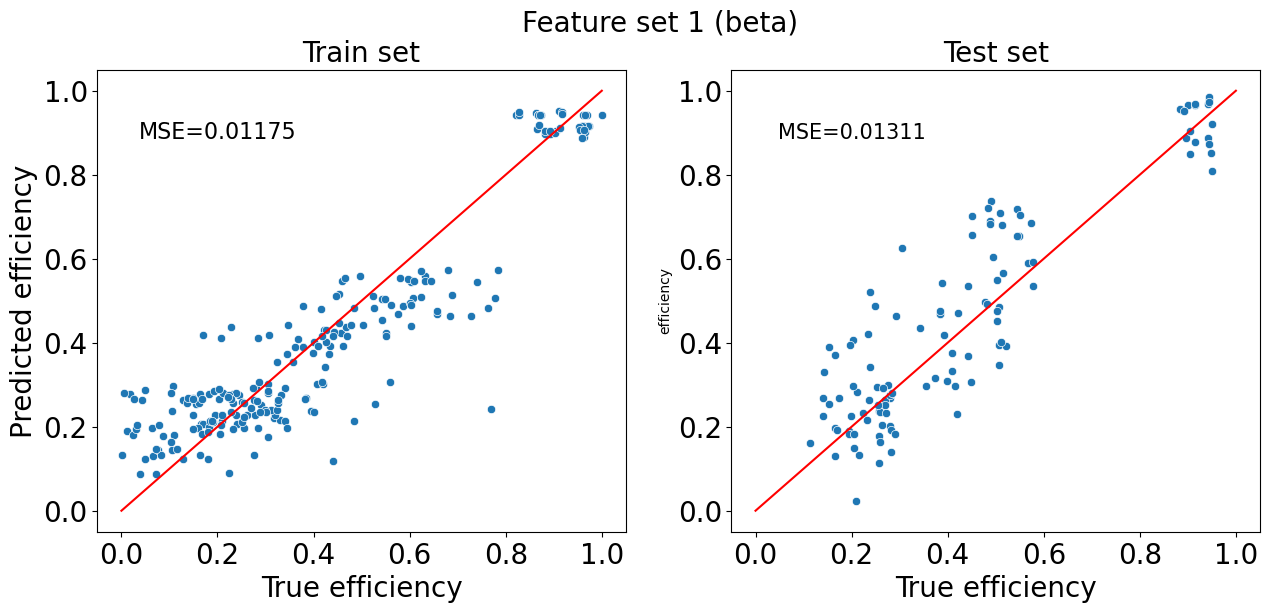

In [105]:
# mse
beta_mse_train = mean_squared_error(betareg_fitted_train['efficiency'],betareg_fitted_train['predicted'])
beta_r2_train = r2_score(betareg_fitted_train['efficiency'],betareg_fitted_train['predicted'])
beta_mse_test = mean_squared_error(betareg_fitted_test['efficiency'],betareg_fitted_test['predicted'])
beta_r2_test = r2_score(betareg_fitted_test['efficiency'],betareg_fitted_test['predicted'])
train_mse.append(beta_mse_train)
train_r2.append(beta_r2_train)
test_mse.append(beta_mse_test)
test_r2.append(beta_r2_test)
fs_name.append('Beta regression with fs1')
pred_vs_true_plot(betareg_fitted_train['predicted'],betareg_fitted_train['efficiency'],beta_mse_train,betareg_fitted_test['efficiency'],betareg_fitted_test['predicted'],beta_mse_test,'Feature set 1 (beta)')
plt.savefig('encapsulation_output/betareg_pred_vs_true.png')

In [106]:
pd.DataFrame({'Feature set':fs_name,"Train_MSE":train_mse,"Train_R2":train_r2,"Test_MSE":test_mse,"Test_R2":test_r2})

,Feature set,Train_MSE,Train_R2,Test_MSE,Test_R2
0,Feasure set 1,0.005221,0.932120,0.010417,0.844804
1,Feature set 2,0.003176,0.958710,0.009955,0.851686
2,Feature set 3,0.003110,0.959564,0.009473,0.858864
3,Beta regression with fs1,0.011746,0.847280,0.013113,0.804637
